# Multi-Degree Drug Interaction Kinetics Test

**Purpose**: Test kinetic behavior of multi-degree drug interaction network using DegreeInteractionSpec

**System**: D → {R1_i} → {I1_i} → O central pathway with higher-degree cascades providing feedback

**Degrees**: [1, 2, 4] where:
  - Degree 1: 1 cascade (R1_1 → I1_1 → O) - central pathway
  - Degree 2: 2 cascades (R2_1 → I2_1, R2_2 → I2_2) - feedback to degree 1
  - Degree 3: 4 cascades (R3_1 → I3_1, ..., R3_4 → I3_4) - feedback to degree 2

**Feedback Regulation Algorithm**:
  - **Mandatory downward regulations**: Each I species in degree n>1 regulates random R/I species in degree n-1
  - **Density-controlled upward regulations**: feedback_density controls proportion of cascades with upward feedback
  - **Adjacent degrees only**: All feedback connects only between degrees n and n-1
  - **Trimming**: When density < 1, upward regulations trimmed from outermost degrees first

**Focus**: Test functionality of multi-degree network, feedback regulations, and drug response

## Initial Setup

Simple path configuration for proper module imports

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


## Imports

Minimal imports focusing on DegreeInteractionSpec

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from models.Specs.DegreeInteractionSpec import DegreeInteractionSpec
from models.Specs.Drug import Drug
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

print("Imports complete")

Imports complete


## 1. Create Multi-Degree Network

Create the network with degree_cascades=[1, 2, 4]
This creates a total of 1+2+4 = 7 cascades × 2 species each + O = 15 species

In [22]:
# Initialize degree interaction specification
degree_spec = DegreeInteractionSpec(degree_cascades=[1,2])

# Generate complete specifications with moderate feedback density
degree_spec.generate_specifications(
    random_seed=42,
    feedback_density=1  # 30% of cascades get upward feedback (mandatory downward always present)
)

print(f"Network created with {len(degree_spec.species_list)} species")
print(f"Degrees: {list(degree_spec.degree_species.keys())}")

# Show species by degree
for degree in [1, 2, 3]:
    species = degree_spec.get_species_by_degree(degree, 'all')
    print(f"Degree {degree} species ({len(species)}): {species[:4]}..." if len(species) > 4 else f"Degree {degree} species: {species}")
    
all_regulations = degree_spec.regulations
print(f"Total regulations: {len(all_regulations)}")

# print regulations one by one 
for reg in all_regulations:
    print(reg)

Network created with 7 species
Degrees: [1, 2]
Degree 1 species: ['R1_1', 'I1_1']
Degree 2 species: ['R2_1', 'R2_2', 'I2_1', 'I2_2']
Degree 3 species: []
Total regulations: 8
Regulation(from_specie='R1_1', to_specie='I1_1', reg_type='up')
Regulation(from_specie='I1_1', to_specie='O', reg_type='up')
Regulation(from_specie='R2_1', to_specie='I2_1', reg_type='up')
Regulation(from_specie='R2_2', to_specie='I2_2', reg_type='up')
Regulation(from_specie='I2_1', to_specie=np.str_('R1_1'), reg_type=np.str_('down'))
Regulation(from_specie='I2_2', to_specie=np.str_('I1_1'), reg_type=np.str_('up'))
Regulation(from_specie=np.str_('R1_1'), to_specie=np.str_('I2_1'), reg_type=np.str_('up'))
Regulation(from_specie=np.str_('I1_1'), to_specie=np.str_('R2_2'), reg_type=np.str_('up'))


## 2. Add Drug Targeting Degree 1 R Species

Drug D will target R1_1 (the only degree 1 R species) with down-regulation

In [23]:
# Create drug D that down-regulates R1_1
drug_d = Drug(
    name="D",
    start_time=5000.0,     # Drug applied at time 500
    default_value=100.0,    # Drug concentration
    regulation=["R1_1"],  # Regulates R1_1 (degree 1, cascade 1)
    regulation_type=["down"]  # Down-regulation decreases activation
)

# Add drug to model
degree_spec.add_drug(drug_d)
print(f"Drug added: {drug_d.name} targeting {drug_d.regulation}")

# Verify drug validation works
print(f"Drug species list: {[d.name for d in degree_spec.drugs]}")
print(f"Total regulations: {len(degree_spec.regulations)}")

Drug added: D targeting ['R1_1']
Drug species list: ['D']
Total regulations: 9


## 3. Generate Model with Controlled Parameters

Create the actual model with parameter ranges for testing functionality

In [24]:
# Generate the model
model = degree_spec.generate_network(
    network_name="MultiDegree_Kinetics",
    mean_range_species=(50, 150),      # Initial concentrations
    rangeScale_params=(0.8, 1.2),      # ±20% variation
    rangeMultiplier_params=(0.9, 1.1), # Small additional variation
    random_seed=42,
    receptor_basal_activation=False     # Receptors have basal activation
)

print(f"Model created: {model.name}")
print(f"Total reactions: {len(model.reactions)}")
print(f"Total states: {len(model.states)}")
print(f"Total parameters: {len(model.parameters)}")

# Show a few key states
key_states = ['R1_1', 'I1_1', 'R2_1', 'I2_1', 'R3_1', 'I3_1', 'O']
available_states = [s for s in key_states if s in model.states]
print(f"Key states available: {available_states}")

Model created: MultiDegree_Kinetics
Total reactions: 14
Total states: 14
Total parameters: 32
Key states available: ['R1_1', 'I1_1', 'R2_1', 'I2_1', 'O']


In [25]:
print(model.get_antimony_model())

model MultiDegree_Kinetics

J0: R1_1a -> R1_1; Vmax_J0*R1_1a/(Km_J0 + R1_1a)
J1: R1_1 -> R1_1a; Kc_J1*R1_1/(Km_J1 + R1_1)/(1 + I2_1a/Ki0_J1 + D/Ki1_J1)
J2: I1_1a -> I1_1; Vmax_J2*I1_1a/(Km_J2 + I1_1a)
J3: I1_1 -> I1_1a; (Kc0_J3*R1_1a+Kc1_J3*I2_2a)*I1_1/(Km_J3 + I1_1)
J4: R2_1a -> R2_1; Vmax_J4*R2_1a/(Km_J4 + R2_1a)
J5: R2_1 -> R2_1a; Vmax_J5*R2_1/(Km_J5 + R2_1)
J6: I2_1a -> I2_1; Vmax_J6*I2_1a/(Km_J6 + I2_1a)
J7: I2_1 -> I2_1a; (Kc0_J7*R2_1a+Kc1_J7*R1_1a)*I2_1/(Km_J7 + I2_1)
J8: R2_2a -> R2_2; Vmax_J8*R2_2a/(Km_J8 + R2_2a)
J9: R2_2 -> R2_2a; (Kc0_J9*I1_1a)*R2_2/(Km_J9 + R2_2)
J10: I2_2a -> I2_2; Vmax_J10*I2_2a/(Km_J10 + I2_2a)
J11: I2_2 -> I2_2a; (Kc0_J11*R2_2a)*I2_2/(Km_J11 + I2_2)
J12: Oa -> O; Vmax_J12*Oa/(Km_J12 + Oa)
J13: O -> Oa; (Kc0_J13*I1_1a)*O/(Km_J13 + O)

# State variables in the system
R1_1a=0
R1_1=101
I1_1a=0
I1_1=62
R2_1a=0
R2_1=99
I2_1a=0
I2_1=54
R2_2a=0
R2_2=134
I2_2a=0
I2_2=88
Oa=0
O=57

# Parameters in the system
Km_J0=95.48267987927224
Vmax_J0=12.043907472649279
Km_

## 4. Swapping parameters for Testing

In [26]:
from models.utils.parameter_mapper import get_parameters_for_state

state_variables = model.get_state_variables()

# filter all state variables with 'a' at the end
state_variables = {k: v for k, v in state_variables.items() if k.endswith('a')}

for state in state_variables.keys():
    params = get_parameters_for_state(model, state)
    forward_parameters = params['as_product']
    backward_parameters = params['as_reactant']
    
    # extract 'km' from the backward parameters list 
    km_b = [p for p in backward_parameters if p.startswith('Km')]
    
    # extract 'km' and also 'ki' from the forward parameters list
    km_f = [p for p in forward_parameters if p.startswith('Km')]
    ki_f = [p for p in forward_parameters if p.startswith('Ki')]
    km_f = km_f + ki_f
    
    # extract 'vmax' and 'kc' from the forward parameters list
    vmax_f = [p for p in forward_parameters if p.startswith('Vmax')]
    kc_f = [p for p in forward_parameters if p.startswith('Kc')]
    vmax_f = vmax_f + kc_f
    
    # extract 'vmax' from the backward parameters list
    vmax_b = [p for p in backward_parameters if p.startswith('Vmax')]
    print(f"State: {state}, Forward params: {forward_parameters}, Backward params: {backward_parameters}")
    print(f"   km forward: {km_f}, km backward: {km_b}")
    print(f"   vmax forward: {vmax_f}, vmax backward: {vmax_b}")

State: R1_1a, Forward params: ['Km_J1', 'Kc_J1', 'Ki0_J1', 'Ki1_J1'], Backward params: ['Km_J0', 'Vmax_J0']
   km forward: ['Km_J1', 'Ki0_J1', 'Ki1_J1'], km backward: ['Km_J0']
   vmax forward: ['Kc_J1'], vmax backward: ['Vmax_J0']
State: I1_1a, Forward params: ['Km_J3', 'Kc0_J3', 'Kc1_J3'], Backward params: ['Km_J2', 'Vmax_J2']
   km forward: ['Km_J3'], km backward: ['Km_J2']
   vmax forward: ['Kc0_J3', 'Kc1_J3'], vmax backward: ['Vmax_J2']
State: R2_1a, Forward params: ['Km_J5', 'Vmax_J5'], Backward params: ['Km_J4', 'Vmax_J4']
   km forward: ['Km_J5'], km backward: ['Km_J4']
   vmax forward: ['Vmax_J5'], vmax backward: ['Vmax_J4']
State: I2_1a, Forward params: ['Km_J7', 'Kc0_J7', 'Kc1_J7'], Backward params: ['Km_J6', 'Vmax_J6']
   km forward: ['Km_J7'], km backward: ['Km_J6']
   vmax forward: ['Kc0_J7', 'Kc1_J7'], vmax backward: ['Vmax_J6']
State: R2_2a, Forward params: ['Km_J9', 'Kc0_J9'], Backward params: ['Km_J8', 'Vmax_J8']
   km forward: ['Km_J9'], km backward: ['Km_J8']
   vma

In [27]:
model.get_state_variables()

{'R1_1a': 0,
 'R1_1': np.int64(101),
 'I1_1a': 0,
 'I1_1': np.int64(62),
 'R2_1a': 0,
 'R2_1': np.int64(99),
 'I2_1a': 0,
 'I2_1': np.int64(54),
 'R2_2a': 0,
 'R2_2': np.int64(134),
 'I2_2a': 0,
 'I2_2': np.int64(88),
 'Oa': 0,
 'O': np.int64(57)}

In [28]:
from models.utils.kinetic_tuner import KineticParameterTuner

tuner = KineticParameterTuner(model, random_seed=42)

updated_params = tuner.generate_parameters(active_percentage_range=(0.3, 0.7))

print("Tuned Parameters:")
for param, value in updated_params.items():
    print(f"  {param}: {value:.3f}")

Tuned Parameters:
  Vmax_J0: 5.720
  Kc_J1: 8.930
  Km_J0: 505.000
  Km_J1: 384.723
  Ki0_J1: 100.000
  Ki1_J1: 100.000
  Vmax_J2: 6.221
  Kc0_J3: 0.046
  Kc1_J3: 0.046
  Km_J2: 310.000
  Km_J3: 310.000
  Vmax_J4: 4.019
  Vmax_J5: 7.252
  Km_J4: 495.000
  Km_J5: 495.000
  Vmax_J6: 4.985
  Kc0_J7: 0.054
  Kc1_J7: 0.056
  Km_J6: 270.000
  Km_J7: 270.000
  Vmax_J8: 18.896
  Kc0_J9: 0.327
  Km_J8: 670.000
  Km_J9: 670.000
  Vmax_J10: 3.688
  Kc0_J11: 0.182
  Km_J10: 440.000
  Km_J11: 440.000
  Vmax_J12: 5.964
  Kc0_J13: 0.309
  Km_J12: 285.000
  Km_J13: 285.000


In [29]:
# Apply tuned parameters to the model

for param in updated_params:
    # param is a dict key, so we need to get its value
    print(f"Setting parameter {param} to {updated_params[param]:.3f}")
    model.set_parameter(param, updated_params[param])

# model.set_parameter("Ki0_J1", 0.01)
    
print(model.get_antimony_model())

Setting parameter Vmax_J0 to 5.720
Setting parameter Kc_J1 to 8.930
Setting parameter Km_J0 to 505.000
Setting parameter Km_J1 to 384.723
Setting parameter Ki0_J1 to 100.000
Setting parameter Ki1_J1 to 100.000
Setting parameter Vmax_J2 to 6.221
Setting parameter Kc0_J3 to 0.046
Setting parameter Kc1_J3 to 0.046
Setting parameter Km_J2 to 310.000
Setting parameter Km_J3 to 310.000
Setting parameter Vmax_J4 to 4.019
Setting parameter Vmax_J5 to 7.252
Setting parameter Km_J4 to 495.000
Setting parameter Km_J5 to 495.000
Setting parameter Vmax_J6 to 4.985
Setting parameter Kc0_J7 to 0.054
Setting parameter Kc1_J7 to 0.056
Setting parameter Km_J6 to 270.000
Setting parameter Km_J7 to 270.000
Setting parameter Vmax_J8 to 18.896
Setting parameter Kc0_J9 to 0.327
Setting parameter Km_J8 to 670.000
Setting parameter Km_J9 to 670.000
Setting parameter Vmax_J10 to 3.688
Setting parameter Kc0_J11 to 0.182
Setting parameter Km_J10 to 440.000
Setting parameter Km_J11 to 440.000
Setting parameter Vma

In [30]:
target_concentrations = tuner.get_target_concentrations()
for t in target_concentrations.items():
    print(f"Target concentration for {t[0]}: {t[1]:.3f}")

Target concentration for R1_1a: 61.568
Target concentration for I1_1a: 29.484
Target concentration for R2_1a: 63.700
Target concentration for I2_1a: 31.263
Target concentration for R2_2a: 45.248
Target concentration for I2_2a: 60.742
Target concentration for Oa: 34.454


In [31]:
from models.utils.parameter_mapper import get_parameters_for_state

regulator_parameter_map = model.get_regulator_parameter_map()
drug_map = regulator_parameter_map.get("D", {})
drug_param = drug_map[0]
print(f"Drug D regulates parameters: {drug_map[0]}")

model.set_parameter(drug_param, 0.01)  # Set to 0 to simulate drug effect

Drug D regulates parameters: Ki1_J1


## 5. Test Basic Functionality with Simulation

Simulate the multi-degree network to verify it works correctly

In [32]:
# Create solver
solver = RoadrunnerSolver()

# Compile model and simulate
try:
    solver.compile(model.get_sbml_model())
    result = solver.simulate(start=0, stop=10000, step=101)  # 0-1000 with 101 points
    
    print("Simulation successful!")
    print(f"Timepoints: {len(result['time'])}")
    print(f"Columns: {list(result.columns)[:10]}...")
    
except Exception as e:
    print(f"Simulation error: {e}")
    # Fallback: try to get antimony model for debugging
    print("\nDebug: Antimony model (first 20 lines):")
    antimony_model = model.get_antimony_model()
    print("\n".join(antimony_model.split("\n")[:20]))

Simulation successful!
Timepoints: 101
Columns: ['time', 'R1_1a', 'R1_1', 'I2_1a', 'I1_1a', 'I1_1', 'I2_2a', 'R2_1a', 'R2_1', 'I2_1']...


In [33]:
# Cross-check if target concentrations were reached at the last timepoint
print("Target Concentration Achievement Analysis")
print("=" * 60)

last_timepoint_pre_drug = result.iloc[-51]  # Get last row of simulation results before drug treatment 
last_timepoint_post_drug = result.iloc[-1]  # Get last row of simulation results after drug treatment

for species, target in target_concentrations.items():
    if species in result.columns:
        final_value = last_timepoint_pre_drug[species]
        difference = final_value - target
        percent_diff = (difference / target) * 100 if target != 0 else 0
        
        status = "✓ Reached" if abs(percent_diff) < 5 else "✗ Not reached"
        
        print(f"{species:8} | Target: {target:8.2f} | Final: {final_value:8.2f} | Diff: {difference:7.2f} ({percent_diff:6.2f}%) | {status}")

Target Concentration Achievement Analysis
R1_1a    | Target:    61.57 | Final:    61.91 | Diff:    0.34 (  0.56%) | ✓ Reached
I1_1a    | Target:    29.48 | Final:    29.45 | Diff:   -0.03 ( -0.11%) | ✓ Reached
R2_1a    | Target:    63.70 | Final:    64.98 | Diff:    1.28 (  2.01%) | ✓ Reached
I2_1a    | Target:    31.26 | Final:    31.86 | Diff:    0.60 (  1.91%) | ✓ Reached
R2_2a    | Target:    45.25 | Final:    43.31 | Diff:   -1.94 ( -4.28%) | ✓ Reached
I2_2a    | Target:    60.74 | Final:    61.26 | Diff:    0.52 (  0.85%) | ✓ Reached
Oa       | Target:    34.45 | Final:    35.00 | Diff:    0.55 (  1.59%) | ✓ Reached


## 6. Visualize Key Species Across Degrees

Plot representative species from each degree to show signal propagation

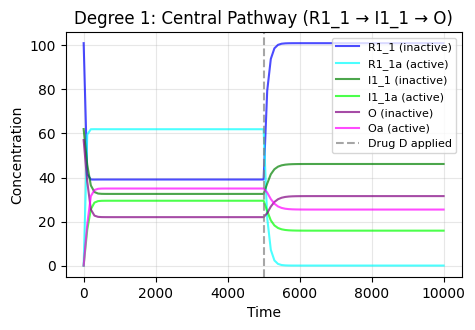

In [34]:
if 'result' in locals():
    plt.figure(figsize=(9, 6))
    
    # Subplot 1: Degree 1 (central pathway)
    plt.subplot(2, 2, 1)
    plt.plot(result['time'], result['R1_1'], label='R1_1 (inactive)', color='blue', alpha=0.7)
    plt.plot(result['time'], result['R1_1a'], label='R1_1a (active)', color='cyan', alpha=0.7)
    plt.plot(result['time'], result['I1_1'], label='I1_1 (inactive)', color='green', alpha=0.7)
    plt.plot(result['time'], result['I1_1a'], label='I1_1a (active)', color='lime', alpha=0.7)
    plt.plot(result['time'], result['O'], label='O (inactive)', color='purple', alpha=0.7)
    plt.plot(result['time'], result['Oa'], label='Oa (active)', color='magenta', alpha=0.7)
    plt.axvline(x=5000, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Degree 1: Central Pathway (R1_1 → I1_1 → O)')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # # Subplot 2: Degree 2 (feedback to degree 1)
    # plt.subplot(2, 2, 2)
    # plt.plot(result['time'], result['R2_1'], label='R2_1 (inactive)', color='blue', alpha=0.7)
    # plt.plot(result['time'], result['R2_1a'], label='R2_1a (active)', color='cyan', alpha=0.7)
    # plt.plot(result['time'], result['I2_1'], label='I2_1 (inactive)', color='green', alpha=0.7)
    # plt.plot(result['time'], result['I2_1a'], label='I2_1a (active)', color='lime', alpha=0.7)
    # plt.axvline(x=5000, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    # plt.xlabel('Time')
    # plt.ylabel('Concentration')
    # plt.title('Degree 2: Feedback Cascade 1')
    # plt.legend(loc='upper right', fontsize=8)
    # plt.grid(True, alpha=0.3)
    
    # # Subplot 3: Degree 3 (feedback to degree 2)
    # plt.subplot(2, 2, 3)
    # plt.plot(result['time'], result['R3_1'], label='R3_1 (inactive)', color='blue', alpha=0.7)
    # plt.plot(result['time'], result['R3_1a'], label='R3_1a (active)', color='cyan', alpha=0.7)
    # plt.plot(result['time'], result['I3_1'], label='I3_1 (inactive)', color='green', alpha=0.7)
    # plt.plot(result['time'], result['I3_1a'], label='I3_1a (active)', color='lime', alpha=0.7)
    # plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    # plt.xlabel('Time')
    # plt.ylabel('Concentration')
    # plt.title('Degree 3: Feedback Cascade 1')
    # plt.legend(loc='upper right', fontsize=8)
    # plt.grid(True, alpha=0.3)
    
    # # Subplot 4: Drug effect summary
    # plt.subplot(2, 2, 4)
    # active_species = ['R1_1a', 'I1_1a', 'Oa', 'R2_1a', 'I2_1a', 'R3_1a', 'I3_1a']
    # colors = plt.cm.Set3(np.linspace(0, 1, len(active_species)))
    
    # for i, species in enumerate(active_species):
    #     if species in result.columns:
    #         plt.plot(result['time'], result[species], label=species, color=colors[i], alpha=0.8)
    
    # plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    # plt.xlabel('Time')
    # plt.ylabel('Active Concentration')
    # plt.title('Active Species Across All Degrees')
    # plt.legend(loc='upper right', fontsize=7)
    # plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Make data

In [56]:
from models.utils.data_generation_helpers import make_data 

state_variables = model.get_state_variables()

# get state variables that end with 'a' (active forms)
active_state_variables = {k: v for k, v in state_variables.items() if k.endswith('a')}

# filter out all active state variables
inactive_state_variables = {k: v for k, v in state_variables.items() if not k.endswith('a')}
# further filter out 'O' if present
if 'O' in inactive_state_variables:
    del inactive_state_variables['O']

kinetic_parameters = model.get_parameters()


X, y = make_data(
    initial_values=inactive_state_variables,
    perturbation_type="lognormal",
    perturbation_params={"shape": 0.5},
    parameter_values=kinetic_parameters,
    param_perturbation_type="lognormal",
    param_perturbation_params={"shape": 0.5},
    n_samples=20000,
    model_spec=degree_spec,
    solver=solver,
    simulation_params={"start": 0, "end": 10000, "points": 101},
    seed=42,
    outcome_var="Oa",
)

In [57]:
X

,R1_1,I1_1,R2_1,I2_1,R2_2,I2_2
0,117.622349,36.860567,144.076650,86.424086,50.517621,45.889992
1,107.666740,52.932266,98.171826,35.249879,208.000147,129.830893
2,104.390207,108.935394,125.070118,35.139920,161.130596,54.483370
3,156.701962,60.471455,90.259483,38.417738,246.931376,81.456739
4,81.528822,51.990843,129.188741,64.825956,164.713254,109.152645
...,...,...,...,...,...,...
19995,56.297288,73.419393,62.689496,33.507132,158.409141,134.559587
19996,69.808367,28.685761,82.083517,73.284609,158.290672,62.061365
19997,121.400454,43.623302,57.171429,111.295585,240.457388,55.415250
19998,130.175067,31.339589,204.010145,74.419337,149.005683,44.787292


In [58]:
y

,Oa
0,0.006582
1,0.008736
2,24.801828
3,1.320662
4,23.219845
...,...
19995,44.871766
19996,27.484345
19997,0.291311
19998,15.692690


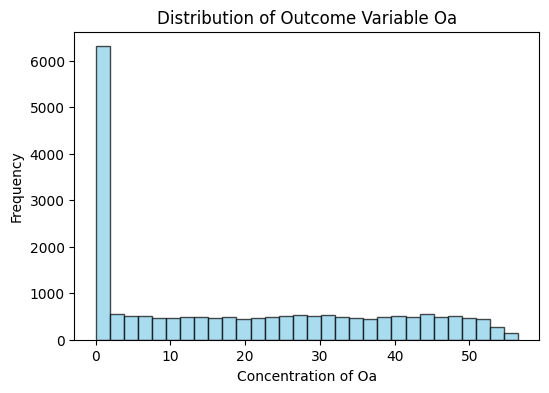

In [59]:
# plot the distribution of y values, the value range between 0 to 3 needs to be plotted as another independent histogram
plt.figure(figsize=(6,4))
plt.hist(y, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Outcome Variable Oa')
plt.xlabel('Concentration of Oa')
plt.ylabel('Frequency')
plt.show()
